# Notebook Monica

# Table of contents

1. [Introduction](#introduction)
2. [Initial Data Exploration and Preprocessing](#initialexploration)
    1. [Importing Packages](#packages)
    2. [Importing datasets](#datasets)
    3. [Exploring the data](#exploring)
3. [Non-Supervised Analysis](#nonsupervised)
4. [Machine Learning](#machinelearning)
5. [Deep Learning ](#deep)
6. [Conclusions](#conclusions)

# Data Analysis using Machine Learning

This project consists in the analysis of dataset, through the use of machine learning algorithms, using Python as a programming language. This Jupyter Notebook is organized into sections, which include the steps of the analysis performed and explain very succinctly the procedures performed and decisions taken during the analysis.

<a name="introduction"></a>

## Introduction

**Data Selection and Context of this Project** 

For the execution of this project, the dataset of the "Novozymes Enzyme Stability Prediction" Competition on the Kaggle platform was selected. You can view the [Competition and Corresponding Data here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/data).

The main goal of this competition is to predict the thermostability of enzyme variants. The experimentally measured thermostability (melting temperature) data includes natural sequences, as well as engineered sequences with single or multiple mutations upon the natural sequences.

The test dataset contains experimental melting temperatures of over 2,413 single mutation variants of an enzyme (GenBank: KOC15878.1), obtained by Novozymes A/S. The wild-type amino acid sequence is:

    VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK

Para esta competição foram dado vários ficheiros para o dessenvolvimento deste trabalho. Nomeadamente:

- `train.csv`: o conjunto de dados de treino com as seguintes colunas (features):
    - `seq_id`: identificador único de cada variante da enzima
    - `protein_sequence`: sequência de aminoácidos de cada variante da enzima. A estabilidade da proteína (`tm`) é determinada pela sua sequência.
    - `pH`: escala de acidez em que a estabilidade de cada variante da enzima foi medida.
    - `data_source`: fonte onde os dados foram publicados
    - `tm`: feature alvo - estabilidade de cada variante da enzima (valores mais altos correspondem a uma maior estabilidade).
    
- `train_updates_20220929.csv`: ficheiro de correção dos dados de treino, onde algumas linhas têm os valores de `pH` e `tm` trocados, para além de ter identificadas as linhas com valores NaN. Para mais detalhes, é possível verificar a [explicação original aqui](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251).

- `test.csv`: o conjunto de dados de teste com as colunas `seq_id` e `protein_sequence`, emq ue o objetivo é prever o valor de `tm` para cada variante da enzima.

- `sample_submission.csv`: um ficheiro de amostra de submissão, com a formatação correta em que o `seq_id` corresponde aos mesmos do ficheiro `test.csv`.

- `wildtype_structure_prediction_af2.pdb`: ficheiro que contém informação sobre a estrutura 3D da enzima, prevista por AlphaFold.

<a name="initialexploration"></a>

## Initial Data Exploration and Preprocessing

This step corresponds to the following objectives:
- description and characterization of the assigned data according to the existing documentation/literature;
- brief description of the characteristics of the data available from the initial exploratory analysis;
- description of data preparation and pre-processing steps;
- initial exploratory graphs that illustrate the main characteristics of the data.

<a name="packages"></a>

### Importing Required Packages

**NOTA: não sei se faz sentido, mas poderiamos explicar pelo menos alguns dos packages, porque é que estamos a usa-los.**

In [1]:
# pip install sgt
# pip install propy

In [2]:
#Imports
# from utils.func import swap_ph_tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.func import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from utils.kmers import KMer_prot
from sklearn.preprocessing import StandardScaler
# import propy
# from propy import PyPro
from sklearn.preprocessing import scale
from sklearn import preprocessing 
from sgt import SGT

<a name="datasets"></a>

### Importing datasets

In [3]:
#Train dataframe
train = pd.read_csv("data/train.csv",index_col="seq_id")
#Validation dataframe (test dataset for the competition scoring)
validation = pd.read_csv("data/test.csv",index_col="seq_id")

In [4]:
train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [5]:
validation.head()

,protein_sequence,pH,data_source
seq_id,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


<a name="exploring"></a>

### Exploring the data

In [6]:
print(f"Train data is divided in {train.shape[0]} samples and {train.shape[1]} features")
print(f"Validation data is divided in {validation.shape[0]} samples and {validation.shape[1]} features")
print(f"Labels for train: {[labels for labels in train.columns]}")

Train data is divided in 31390 samples and 4 features
Validation data is divided in 2413 samples and 3 features
Labels for train: ['protein_sequence', 'pH', 'data_source', 'tm']


In [7]:
train.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [8]:
validation.describe()

,pH
count,2413.0
mean,8.0
std,0.0
min,8.0
25%,8.0
50%,8.0
75%,8.0
max,8.0


With this information, we can make some observations:

- the `data_source` variable is not nominal, so we can't more information about this feature.
- the `validation` dataset corresponds to ~7% of total samples, while `train` dataset corresponds to ~93%.
- the `validation` dataset corresponds to the test dataset for the competition scoring, so it misses the `tm` feature (the variable to be predicted).
- the `pH` variable on the `train` dataset has a maximum value of 64.9.
- the `pH` variable on the `train` dataset has 31104 samples, while `tm` has 31390 (which is the total number of samples of that dataset).
- the `pH` variable on the `validation` dataset has all the samples with the same value of 8. 

#### Data sources

Para verificar a distribuição das sources na bases de dados, converte-se para uma variável nominal e observa-se a distribuição.

In [9]:
len(pd.unique(train["data_source"]))

325

In [10]:
print(train.data_source)

seq_id
0        doi.org/10.1038/s41592-020-0801-4
1        doi.org/10.1038/s41592-020-0801-4
2        doi.org/10.1038/s41592-020-0801-4
3        doi.org/10.1038/s41592-020-0801-4
4        doi.org/10.1038/s41592-020-0801-4
                       ...                
31385    doi.org/10.1038/s41592-020-0801-4
31386    doi.org/10.1038/s41592-020-0801-4
31387    doi.org/10.1038/s41592-020-0801-4
31388    doi.org/10.1038/s41592-020-0801-4
31389    doi.org/10.1038/s41592-020-0801-4
Name: data_source, Length: 31390, dtype: object


In [11]:
sources = {}
count = 1
for n, i in enumerate(train.data_source):
    if i not in sources.keys():
        sources[i] = count
        train.data_source[n] = sources[i]
        count += 1
    else:
        train.data_source[n] = sources[i]

# print(train.data_source)

/tmp/ipykernel_36200/722519737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]
/tmp/ipykernel_36200/722519737.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]


In [12]:
print(pd.Series(train.data_source).describe())

count     31390
unique      325
top           1
freq      24525
Name: data_source, dtype: int64


In [13]:
unique, counts = np.unique(train.data_source, return_counts=True)
dicion = dict(zip(unique, counts))

for i,a in dicion.items():
    if a > 300: # 1% do total counts
        print('Data Source: ', i, 'Counts: ', a)
        print('Percentage of total counts: ', round((a*100)/train.data_source.describe()[0], 2), '%')


Data Source:  1 Counts:  24525
Percentage of total counts:  78.13 %
Data Source:  2 Counts:  3347
Percentage of total counts:  10.66 %


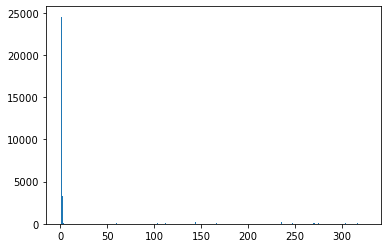

In [14]:
plt.hist(train.data_source, bins=325)
plt.show()

We can observe that 78% of the dataset corresponds to one unique data source.

Although this feature (`data source`) is interesting to explore how the data was obtained, it contains a large number of null values (NA) and is not essential to the main goal of this project (**to predict `tm`**).
So, it was decided to drop this column from the dataset (presented further ahead).

#### Swap pH e tm (to correct data)

Here it is possible to verify that the `pH` variable has errors in the "train" dataset since its maximum is 64.9 (a value impossible to obtain). According to the source of the data, the variable pH and tm have some examples with the values changed. Thus, it is necessary to change these values in the identified sequences (dataset "train_updates").

Here it is possible to verify that the `pH` variable has errors in the `train` dataset, since its maximum is 64.9 (impossible pH value to obtain). According to the [source of the competition](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251), the variable `pH` and `tm` has some samples with the values swapped. Thus, it is necessary to change these values in the identified sequences (dataset `train_updates`).

In [15]:
update_train = pd.read_csv("data/train_updates_20220929.csv",index_col="seq_id")
train = swap_ph_tm(train,update_train)

In [16]:
print(f"Labels: {[labels for labels in train.columns]}")
print(f"Labels: {[labels for labels in validation.columns]}")

Labels: ['protein_sequence', 'pH', 'data_source', 'tm']
Labels: ['protein_sequence', 'pH', 'data_source']


#### Drop NA Values

As said above, the column `data_source` will be eliminated from the dataset, as well as the rest of the samples with null values.

In [17]:
print("Remove data_source")
train = train.drop(columns="data_source")
validation = validation.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Validation data is divided in {validation.shape[0]} lines and {validation.shape[1]} col")
print("We want to predict tm values for test data")

Remove data_source
Train data is divided in 28981 lines and 3 col
Validation data is divided in 2413 lines and 2 col
We want to predict tm values for test data


In [18]:
print(train.isnull().sum().sort_values(ascending=False))
print(validation.isnull().sum().sort_values(ascending=False))

pH                  286
protein_sequence      0
tm                    0
dtype: int64
protein_sequence    0
pH                  0
dtype: int64


In [19]:
missing_data = train[train["pH"].isnull()]
# missing_data

In [20]:
train= train.drop((missing_data).index)
train

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6


In [21]:
print(train.isnull().sum().sort_values(ascending=False))
print(validation.isnull().sum().sort_values(ascending=False))

protein_sequence    0
pH                  0
tm                  0
dtype: int64
protein_sequence    0
pH                  0
dtype: int64


#### Exploring Protein Sequence feature

In [22]:
# Tamanho das sequencias de proteina e distribuição
lista = [len(train['protein_sequence'].iat[i]) for i in range(len(train))]
pd.Series(lista).describe()

count    28695.000000
mean       451.729535
std        416.889872
min          5.000000
25%        210.000000
50%        352.000000
75%        537.000000
max       8798.000000
dtype: float64

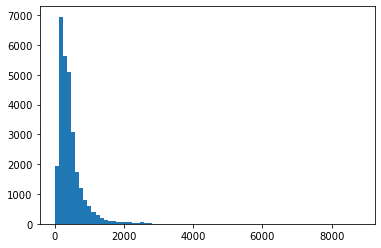

In [23]:
plt.hist(lista, bins=75)
plt.show()

#adicionar titulos aos eixos e grafico

#### Summary

In [24]:
train.describe()

,pH,tm
count,28695.000000,28695.000000
mean,6.872467,51.385604
std,0.793184,12.076609
min,1.990000,25.100000
25%,7.000000,43.700000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


In [25]:
print(f"Train data is divided in {train.shape[0]} samples and {train.shape[1]} features")
print(f"Labels for train: {[labels for labels in train.columns]}")

Train data is divided in 28695 samples and 3 features
Labels for train: ['protein_sequence', 'pH', 'tm']


Now, other observations can be made:

- the `train` dataset without null values has a total of 28695 samples and only 3 features: `protein_sequence`, `pH` and `tm`.
- the `pH` feature has values between 1.9 and 11 but, the majority of samples have a pH value of 7.
- the `tm` feature has values between 25 and 130, but 50% of samples have a smaller range: 44-55.
- the `protein_sequence` samples have a large range of lenghts (between 5 and 8798), but 50% of samples have lenghts between 210 and 537). The mean lenght of the 28695 sequences is 451.
- to use some machine learning techniques it is needed to transform the feature `protein_sequence` into descriptors (multiple features), such as the frequency of the aminoacids, composition, physicochemical properties of the protein, and many others.

<a name="nonsupervised"></a>

## Non-Supervised Analysis]

<a name="machinelearning"></a>

## Machine Learning

<a name="deep"></a>

## Deep Learning

<a name="conclusions"></a>

## Conclusions